# **Práctica 1: KNN y selección de atributos**

**Eva Blazquez y Gabriela Damas**

## **1. Implementación y uso de KNN**

a) Descargue los datos del siguiente problema relacionado con el cáncer de
mama:

In [1]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

b) Preprocese el dataset siguiendo estos pasos: (1) separe los atributos de la etiquetas; (2) divida los datos en una partición con el 70 % de los puntos para training y el 30 % de los puntos para test; (3) normalice los datos

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# (1) Separar atributos de las etiquetas
X, y = data.data, data.target

# (2) Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# (3) Normalizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

c) Si hubiera datos ausentes (missing values) y estos se completaran, ¿cómo cree que influiría el orden en el que se realizan las operaciones de normalizar y completar? ¿Qué pasaría si primero se completan los datos ausentes y luego se normaliza? ¿Y si primero se normaliza y luego se realiza la partición training-test ?

**Respuesta:**  
- Si primero completas los missing values y luego normalizas, la normalización se hace sobre datos completos, lo cual es correcto.
- Si primero normalizas y luego completas, los valores imputados no estarán correctamente escalados respecto al resto.
- Si primero normalizas y luego partes en train/test, puedes tener "fugas de información" porque la media y desviación estándar se calculan usando datos de test.

d) A continuación, complete la clase KNNClassifier, cuyos atributos son el número de vecinos y una función distancia (una función cuyas entradas son dos vectores de la misma dimensión, y cuya salida es un número real positivo). Complete el constructor y los métodos fit y predict.

e) Utilice la clase anterior para predecir las etiquetas de los datos de test, con un número de vecinos k, fijo pero arbitrario.

In [3]:
from KNNClassifier import KNNClassifier
from sklearn.metrics import accuracy_score

knn = KNNClassifier(k=5)
knn.fit(X_train_scaled, y_train)
y_predcustom = knn.predict(X_test_scaled)
print("Accuracy en test:", accuracy_score(y_test, y_predcustom))

Accuracy en test: 0.9590643274853801


f) Responda a la siguiente pregunta: ¿Qué ocurriría si hubiera un desbalanceo de clases en el conjunto de entrenamiento? Si esto supone un problema, ¿podría proporcionar una solución?

**Respuesta:** Si hay desbalanceo de clases, KNN puede estar sesgado hacia la clase mayoritaria. Una solución es ponderar el voto de los vecinos por la inversa de la distancia o usar técnicas de sobremuestreo/submuestreo, o ajustar el umbral de decisión.

g) Responda a la siguiente pregunta: ¿Cuál es el coste en memoria del algoritmo KNN? ¿Se le ocurre alguna forma de reducirlo?

**Respuesta:** KNN almacena todo el conjunto de entrenamiento, por lo que el coste en memoria es $O(n \cdot d)$, siendo n el número de muestras y d el número de atributos. Para reducirlo se pueden usar prototipos (condensed KNN), clustering, o reducción de dimensionalidad.

h) Utilice la función KNeighborsClassifier de la biblioteca de sklearn y, para el mismo número de vecinos k prediga las etiquetas del conjunto de test $y_{\text{predsk}}$. Si $y_{\text{predsk}}$ son las prediciones de su modelo, ¿cuál es el error medio entre las predicciones $y_{\text{predsk}}$ e $y_{\text{predcustom}}$? ¿Por qué? 

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error

knn_sk = KNeighborsClassifier(n_neighbors=5)
knn_sk.fit(X_train_scaled, y_train)
y_predsk = knn_sk.predict(X_test_scaled)
print("Error medio entre predicciones:", mean_squared_error(y_predcustom, y_predsk))

Error medio entre predicciones: 0.0


i) Se encuentra usted a un individuo que afirma que, en vez de utilizar KNN, el prefiere usar la siguiente alternativa. Para predecir la etiqueta del punto $x$, toma los tres puntos más cercanos a $x$ en el conjunto de training. Si las distancias de estos tres puntos al punto $x$ son $d_1$, $d_2$ e $d_3$, y sus respectivas etiquetas son $y_1$, $y_2$ e $y_3$, la predicción vendrá dada por

$$
f(x) = \operatorname{sign} \left( \sum_{i=1}^{3} \frac{y_i}{d_i} \right).
$$

¿Considera que este método es mejor que KNN con k = 3? ¿Por qué?

**Respuesta 1:** El método propuesto es KNN ponderado por la inversa de la distancia. Puede ser mejor si hay vecinos cercanos de distinta clase, pero es sensible a distancias pequeñas (puede ser inestable si $d_i \approx 0$).

**Respuesta 2:** El método ponderado por la inversa de la distancia puede ser mejor si los vecinos más cercanos son más relevantes, pero es más sensible a outliers. KNN estándar da igual peso a los k vecinos. La elección depende del problema.

## **2. Optimización de KNN**

a) Encuentre, utilizando validación cruzada, el número de vecinos óptimos, $k_{\text{opt}}$.

In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


pipe=Pipeline([('scaler', StandardScaler()), ('knn', KNNClassifier())])

param_grid = {'knn__k': list(range(1, 31))}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='accuracy')
grid.fit(X_train, y_train)

print("k óptimo:", grid.best_params_['knn__k'])

k óptimo: 6


b) De la métrica de accuracy sobre el conjunto de test del clasificador KNN usando el valor $k_{\text{opt}}$ obtenido.

In [6]:
best_knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNNClassifier(k=grid.best_params_['knn__k']))
])

best_knn_pipe.fit(X_train, y_train)

y_pred = best_knn_pipe.predict(X_test)

print(f"Accuracy sobre el conjunto de test: ", accuracy_score(y_test, y_pred))

Accuracy sobre el conjunto de test:  0.9590643274853801


c) ¿Cree que el valor $k_{\text{opt}}$ encontrado es el que proporciona mejor accuracy en el conjunto de test?

**Respuesta:**  
No necesariamente. El mejor $k$ en validación cruzada sobre train puede no ser el mejor en test, pero suele generalizar bien.

k_opt es el valor que se espera que generalice mejor, según la validación cruzada. No necesariamente proporciona la máxima precisión en el test, pero es el que debemos usar para evaluar el desempeño final sin introducir sesgo.

d) Muestre en una gráfica el accuracy frente al número de vecinos, tanto para el conjunto de training como para el de test.

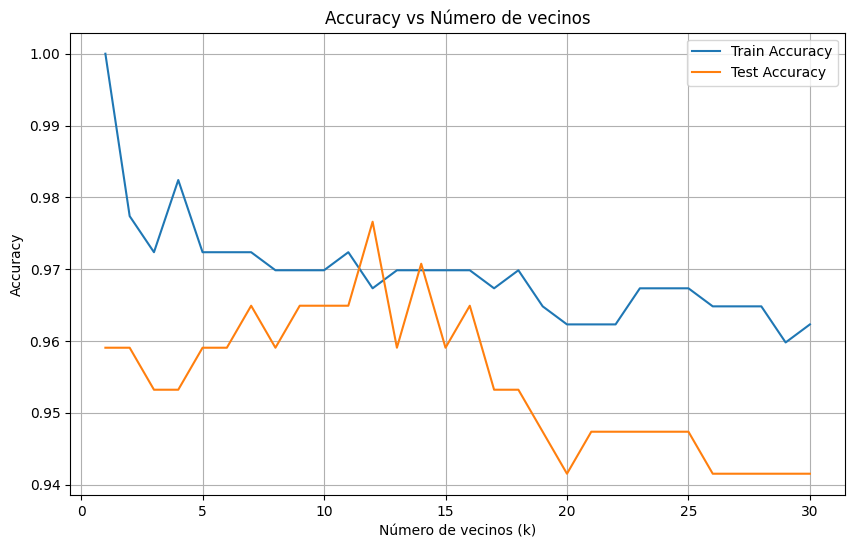

In [7]:
import matplotlib.pyplot as plt

k_values = range(1, 31)
train_acc = []
test_acc = []

for k in k_values:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNNClassifier(k=k))
    ])
    
    pipe.fit(X_train, y_train)
    
    y_train_pred = pipe.predict(X_train)
    train_acc.append(accuracy_score(y_train, y_train_pred))
    
    y_test_pred = pipe.predict(X_test)
    test_acc.append(accuracy_score(y_test, y_test_pred))

plt.figure(figsize=(10,6))
plt.plot(k_values, train_acc, label='Train Accuracy')
plt.plot(k_values, test_acc, label='Test Accuracy')
plt.xlabel('Número de vecinos (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Número de vecinos')
plt.grid(True)
plt.legend()
plt.show()

e) Repita los experimentos anteriores utilizando la distancia de Minkowski para $p ∈ {1, 2, 10}$.

In [8]:
p_values = [1, 2, 10]
k_range = list(range(1, 31))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

k_opt_dict = {}

for p in p_values:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNNClassifier(p=p))
    ])
    
    param_grid = {'knn__k': k_range}
    
    grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='accuracy')
    grid.fit(X_train, y_train)
    
    k_opt_dict[p] = grid.best_params_['knn__k']

for p, k_opt in k_opt_dict.items():
    print(f'p={p}, k_opt={k_opt}')

p=1, k_opt=6
p=2, k_opt=6
p=10, k_opt=6


In [9]:
import numpy as np

for p, k_opt in k_opt_dict.items():
    knn = KNNClassifier(k=k_opt, p=p)
    
    knn.fit(X_train, y_train)
    
    y_test_pred = knn.predict(X_test)
    
    print(f'p={p}, test accuracy=',np.mean(y_test_pred == y_test) )

p=1, test accuracy= 0.9298245614035088
p=2, test accuracy= 0.9181286549707602
p=10, test accuracy= 0.9181286549707602


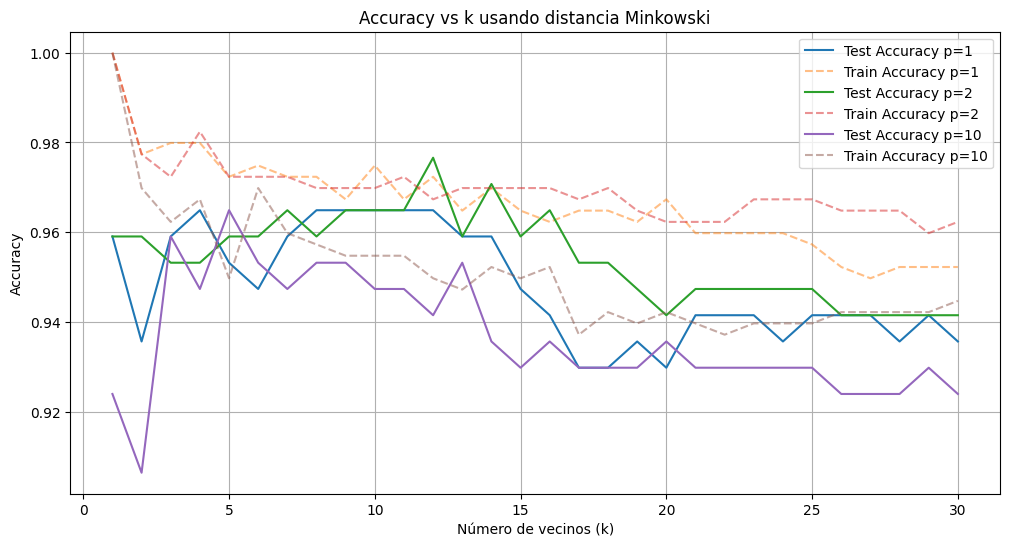

In [10]:
plt.figure(figsize=(12,6))

for p in p_values:
    train_acc = []
    test_acc = []
    for k in k_values:
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNNClassifier(k=k, p=p))
        ])
        
        pipe.fit(X_train, y_train)
        
        y_train_pred = pipe.predict(X_train)
        train_acc.append(accuracy_score(y_train, y_train_pred))
        
        y_test_pred = pipe.predict(X_test)
        test_acc.append(accuracy_score(y_test, y_test_pred))
    
    plt.plot(k_values, test_acc, label=f'Test Accuracy p={p}')
    plt.plot(k_values, train_acc, linestyle='--', alpha=0.5, label=f'Train Accuracy p={p}')

plt.xlabel('Número de vecinos (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k usando distancia Minkowski')
plt.grid(True)
plt.legend()
plt.show()

f) ¿Cómo afecta el valor de $p$ a los resultados? ¿Qué $p$ cree que es mejor?

**Respuesta:**  
Valores bajos de $p$ (como 1) dan más peso a diferencias individuales, valores altos (como 10) hacen que la distancia esté dominada por la mayor diferencia. Suele funcionar mejor $p=2$ (euclídea) o $p=1$ (Manhattan).

## **3.Selección de atributos**

A continuación procederemos a la reducción de la dimensión de los datos.

a) Usando el método VarianceThreshold de sklearn.feature selection para cierto umbral fijo u, elimine los atributos que no superen dicho umbral.

b) Analice cómo afecta la selección de atributos al accuracy del modelo. Para ello, fijado un valor de k para KNN, calcule accuracy en test. El conjunto de entrenamiento tendr ́a los atributos seleccionados para un umbral $u ∈ [0, 1]$ concreto. El resultado ser ́a una gr ́afica con el accuracy frente al umbral $u$.

c) ¿Tienen sentido los casos $u=0$ y $u=1$?

**Respuesta:**  
$u=0$: no se elimina ningún atributo (salvo los constantes).  
$u=1$: probablemente elimina todos los atributos (varianzas suelen ser <1 tras normalizar).

d) Ahora seleccione los mejores atributos del conjunto de datos utilizando SelectKBest de la librería scikit-learn. Siga los siguientes pasos:

1) Importe el método SelectKBest:

In [11]:
from sklearn.feature_selection import SelectKBest

2) Utilice una estadística univariada como f classif para la selección de atributos:

In [12]:
from sklearn.feature_selection import f_classif

3) Seleccione los mejores K atributos:

In [13]:
selector = SelectKBest(score_func=f_classif, k=K)
selector.fit(X, y)
X_selected = selector.transform(X)

NameError: name 'K' is not defined

**Recuerda:**  
Debes completar también la clase `mRMR.py` para la selección de atributos basada en relevancia y redundancia, y documentar todo en tu notebook.

e) Combinando el método de selección de atributos con el clasificador KNN para un valor de k fijo, determinte cuál es el mejor valor de K. Nótese que k hace referencia al número de vecinos en KNN y K es el número de atributos seleccionado.

f) A continuación implemente el método de selección de atributos mRMR. Para ello, complete el archivo mRMR.py.

g) ¿Cuál es su mejor valor de k?

h) ¿Cuál es el papel de la información mutua en el método mRMR? ¿Se podría sustituir por otra métrica?

i) ¿Qué método de selección de atributos, de los dos utilizados, considera que es mejor?